In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl
import tensorflow.keras.layers as tkl
from tensorflow.keras import datasets
import tensorflow.keras.models as tkm
import tensorflow_datasets as tfds

from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
import matplotlib.patches as patches
import time

from utils.model import VGG16, ResNet50
from utils.lrp_CNN import LRP, SelectiveLRP, SGLRP, CLRP

os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
### Import dataset
dataset, info = tfds.load('imagenet2012', split='validation', with_info=True, data_dir='/notebooks/datasets')

In [3]:
### Set model
model = VGG16()
# model = ResNet50()

orimodel = tf.keras.applications.VGG16()
# orimodel = tf.keras.applications.ResNet50()
#print(orimodel.summary())

### Set algorithms 
lrp = LRP(model, 'plainLRP')
slrp = SelectiveLRP(model, 'SelectiveLRP')
sglrp = SGLRP(model, 'SGLRP')
clrp = CLRP(model, 'CLRP')

### Get labels
label_file = 'data/imagenet_label.txt'

labeldict = {}
with open(label_file) as f:
    for line in f:
        (key, val) = line.split(":")
        labeldict[int(key)] = val

In [4]:
### Preparing image transform
WIDTH = 224
BATCH_SIZE = 6

def transform(tensor):
    img = tensor['image']
    img = tf.image.resize(img, (WIDTH, WIDTH))
    tensor['image'] = img
    return tensor

dataset = dataset.map(lambda x : transform(x)).batch(BATCH_SIZE)
dataiter = iter(dataset)

In [5]:
batch = dataiter.next()

### Get image informations
image = batch['image']
label = batch['label']
filename = batch['file_name']

oriimg = image.numpy().copy() / 255.0
inputimg = preprocess_input(image)

### Predict
_, predict = model(inputimg)
predict = tf.nn.softmax(predict)
predict = tf.argmax(predict, axis=1)


### Make heatmaps

start_time = time.time()
plainlrp_p = [lrp(tf.reshape(inputimg[i], (1,*inputimg[i].shape)), predict[i]) for i in range(BATCH_SIZE)]
print("lrp : ", time.time() - start_time, "s")

start_time = time.time()
selectivelrp_p = [slrp(tf.reshape(inputimg[i], (1,*inputimg[i].shape)), predict[i]) for i in range(BATCH_SIZE)]
print("slrp : ", time.time() - start_time, "s")

start_time = time.time()
sglrp_p = [sglrp(tf.reshape(inputimg[i], (1,*inputimg[i].shape)), predict[i]) for i in range(BATCH_SIZE)]
print("sglrp : ", time.time() - start_time, "s")

start_time = time.time()
clrp_p = [clrp(tf.reshape(inputimg[i], (1,*inputimg[i].shape)), predict[i]) for i in range(BATCH_SIZE)]
print("clrp : ", time.time() - start_time, "s")

plainlrp_l = [lrp(tf.reshape(inputimg[i], (1,*inputimg[i].shape)), label[i]) for i in range(BATCH_SIZE)]
selectivelrp_l = [slrp(tf.reshape(inputimg[i], (1,*inputimg[i].shape)), label[i]) for i in range(BATCH_SIZE)]
sglrp_l = [sglrp(tf.reshape(inputimg[i], (1,*inputimg[i].shape)), label[i]) for i in range(BATCH_SIZE)]
clrp_l = [clrp(tf.reshape(inputimg[i], (1,*inputimg[i].shape)), label[i]) for i in range(BATCH_SIZE)]

lrp :  0.6850600242614746 s
slrp :  0.43122005462646484 s
sglrp :  0.39936065673828125 s
clrp :  0.3965926170349121 s


Label : common newt, Prediction : common newt
Label : Granny Smith, Prediction : Granny Smith
Label : kelpie, Prediction : German shepherd
Label : great grey owl, Prediction : great grey owl
Label : grocery store, Prediction : bakery
Label : kimono, Prediction : kimono


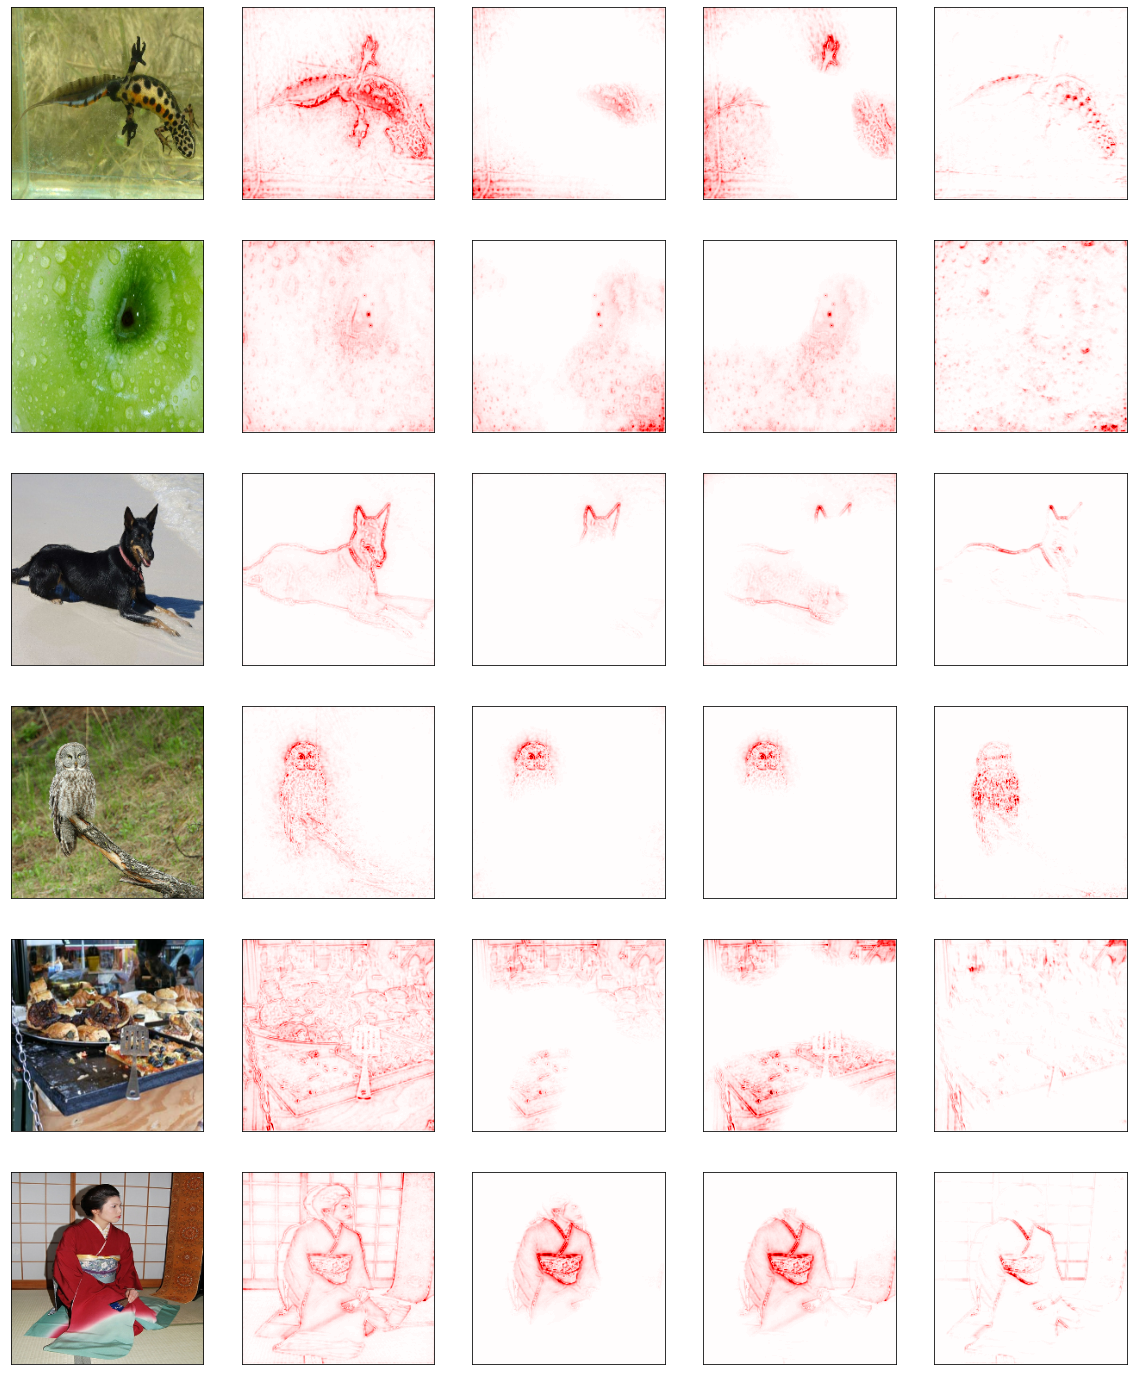

In [6]:
plt.figure(figsize=(20,25))

for i in range(BATCH_SIZE):
    
    labelstr = labeldict[int(label[i])].split(',')[0][2:]
    predictstr = labeldict[int(predict[i])].split(',')[0][2:]
    if labelstr[-1] == '\'' : labelstr = labelstr[:-1]
    if predictstr[-1] == '\'' : predictstr = predictstr[:-1]
    
    ### Show LRP heatmap
    plt.subplot(BATCH_SIZE, 5, 5*i+1)
    sampleimg = oriimg[i]
    plt.imshow(sampleimg)
    print("Label : " + labelstr + ", Prediction : " + predictstr)
    plt.xticks([])
    plt.yticks([])
    
    ### Show SLRP heatmap
    plt.subplot(BATCH_SIZE, 5, 5*i+2)
    #img = plainlrp_p[i].numpy()
    img = plainlrp_l[i].numpy()
    img = img.reshape(img.shape[1:]).max(axis=2)
    img = np.maximum(img, 0)
    vmax = img.max()
    plt.imshow(img, vmin=-vmax, vmax=vmax, cmap='seismic')
    plt.xticks([])
    plt.yticks([])
    
    ### Show CLRP heatmap
    plt.subplot(BATCH_SIZE, 5, 5*i+3)
    #img = clrp_p[i].numpy()
    img = clrp_l[i].numpy()
    img = img.reshape(img.shape[1:]).max(axis=2)
    vmax = np.abs(img).max()
    img = np.maximum(img, 0)
    plt.imshow(img, vmin=-vmax, vmax=vmax, cmap='seismic')
    plt.xticks([])
    plt.yticks([])
    
    ### Show SGLRP heatmap
    plt.subplot(BATCH_SIZE, 5, 5*i+4)
    #img = sglrp_p[i].numpy()
    img = sglrp_l[i].numpy()
    img = img.reshape(img.shape[1:]).max(axis=2)
    img = np.maximum(img, 0)
    vmax = np.abs(img).max()
    plt.imshow(img, vmin=-vmax, vmax=vmax, cmap='seismic')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(BATCH_SIZE, 5, 5*i+5)
    #img = selectivelrp_p[i].numpy()
    img = selectivelrp_l[i].numpy()
    img = img.reshape(img.shape[1:]).max(axis=2)
    img = np.maximum(img, 0)
    vmax = img.max()
    plt.imshow(img, vmin=-vmax, vmax=vmax, cmap='seismic')
    plt.xticks([])
    plt.yticks([])
    
# plt.savefig('figlabel.png')